# References

1. If you are playing around with this notebook, you might want to look at the [Seaborn docs](https://seaborn.pydata.org/tutorial/distributions.html)
2. If you want to go deeper into the math, or just want an alternate explanation, then check out:
    1. [Readings for statistical inference](https://moderndive.com/7-sampling.html)
    2. [Bootstrapping](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf)

# Glossary

1. Population
2. Sampling
3. Emperical distribution
4. Statistic - Point/Interval
5. Sampling distribution
6. Bootstrapping

In [294]:
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd

sns.set_style("darkgrid")

# Sampling

To **sample** from a set, is to choose elements from that set. In a **random sample**,
the elements are chosen randomly.

The subtlety here, is that the set or **population** can have multiple instances of the same element. This means each *unique* element has a distinct and independent probability of being chosen. A spread of probabilities is called a **distribution**, and in this case, the *true distribution* of the population.

In [295]:
def plot_distribution(points, histtype="stepfilled", density=True):
    _ = plt.hist(points, bins="auto", histtype=histtype, density=density)
    return

def plot_distribution_sns(points, **kwargs):
    _ = sns.displot(points, **kwargs)
    return

In [296]:
def fit_to_distr(data, distr, fmt="r-"):
    params  = distr.fit(data)
    
    x = np.linspace(np.min(data), np.max(data), len(data))
    fitted_data = distr.pdf(x, *params)
        
    plot_distribution_sns(data, stat="density")
    _ = plt.plot(x,fitted_data, fmt)
    return

In [297]:
def print_stats(points):
    print(f"Mean: {np.mean(points)}")
    print(f"Std dev: {np.std(points)}")
    return

In [298]:
N_set = 100000
N_samples = 1000

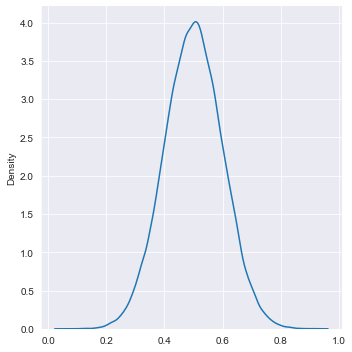

In [299]:
# population
population = list(stats.norm(.5, .1).rvs(N_set))
# distribution
plot_distribution_sns(population, kind="kde")

## Random sampling

The population is pictured above. We will now *randomly sample* elements from it. There are two ways to do this:

### without replacement

Choose a random sample of `N_samples`. Successive choices *depend* on previous one

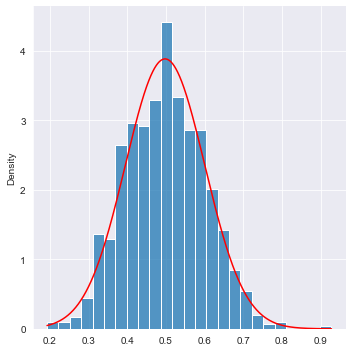

In [300]:
samples = random.sample(population, N_samples)
fit_to_distr(samples, stats.norm)

### with replacement

independent random sampling. probability of choosing an element is *not dependent* on earlier choices

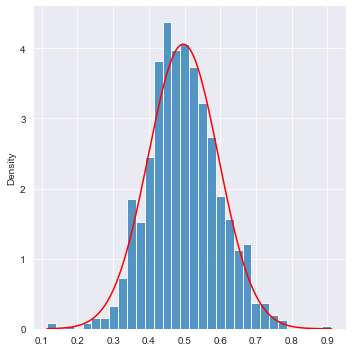

In [301]:
samples = random.choices(population, k=N_samples)
fit_to_distr(samples, stats.norm)

### Notice that

sampling without replacement **alters the underlying distribution of the population** from which you are sampling. To see this, we visualize the population for both processes:

In [302]:
population = list(stats.norm(.5, .1).rvs(1000))

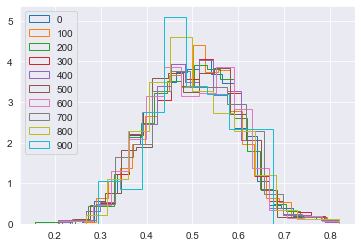

In [303]:
## this simulates sampling without replacement

sampling_set = population
legend = []
for i in range(len(population)):
    idx = random.choice(range(len(sampling_set)))
    sampling_set = sampling_set[:idx] + sampling_set[idx + 1:]
    if i%(N_samples/10)==0:
        plot_distribution(sampling_set, histtype="step", density=True)
        legend.append(i)
_ = plt.legend(legend)

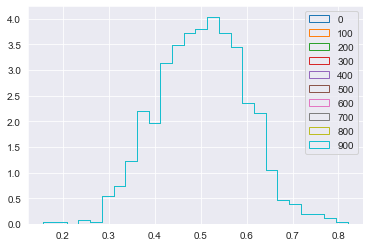

In [304]:
## this simulates sampling with replacement

sampling_set = population
legend = []
for i in range(1000):
    idx = random.choice(range(len(sampling_set)))
#     sampling_set = sampling_set[:idx] + sampling_set[idx + 1:]
    if i%(N_samples/10)==0:
        plot_distribution(sampling_set, histtype="step", density=True)
        legend.append(i)
_ = plt.legend(legend)

We abstract out this process of *random sampling with replacement* from a set, and call the resulting function a **random variable**.

# Emperical Distribution

This is simply the probability *distribution* of a random variable sampled from a population. The name contrasts against the *true* distribution of a population (also called *population distribution*, sometimes).

Since the distribution of a population is a probability mapping over the elements/events of the population, we can express it a function. Which is what we will do below.

### Examples

In [305]:
## Standard
distributions = {
    "uniform": stats.uniform(),
    "normal": stats.norm(.5, .1),
    "beta": stats.beta(3,9),
}

In [306]:
## FANCY (but random)
#### random points, independently sampled from a randomly chosen distribution
class Fancy:
    def __init__(self, distrs: dict):
        self.distrs = distrs
    
    def rvs(self, n: int):
        import random
        return [random.choice(list(self.distrs.values())).rvs() for i in range(n)]

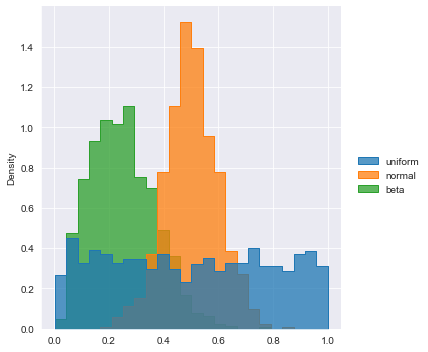

In [307]:
df = pd.DataFrame()
for key, distr in distributions.items():
    df[key] = distr.rvs(size=N_samples)
plot_distribution_sns(df, element="step", stat="density")

## Point estimates

aka "measures of central tendencies"

In [308]:
reps = {}
for key, distr in distributions.items():
    points = distr.rvs(size=N_samples)
    reps[key] = {"mean":np.mean(points), "median":np.median(points)}

print(pd.DataFrame(reps))

         uniform    normal      beta
mean    0.493994  0.501278  0.249951
median  0.493138  0.502586  0.234528


In [309]:
points = Fancy(distributions).rvs(N_samples)
print(f"Mean: {np.mean(points)}")
print(f"Median: {np.median(points)}")

Mean: 0.421344728828663
Median: 0.41413560769037383


## Interval estimates

Since we are dealing with a *probability* distribution, the area under *whole* curve is 1. More generally, we can talk about **area under curve over an interval**. This represents the probability of the random variable lying in that interval. 

The interval associated with a probability is called the **percentile**, when it is calculated w.r.t `-∞`. But such intervals can be defined w.r.t *any real number*, and this generalization is called a **confidence interval**.

In [310]:
## Median -> Percentiles

assert np.median(points) == np.percentile(points, 0.5*100)

In [311]:
## Confidence intervals

def percentile_around_mean(points, q=95, print=False):
    mean_percentile = np.mean([np.array(points)<np.mean(points)])*100
    if print:
        print("Mean percentile: ", mean_percentile)

    lower = mean_percentile - q/2 if mean_percentile > (q/2) else 0
    upper = mean_percentile + q/2 if mean_percentile + (q/2) < 100 else 100
    return np.percentile(points, lower), np.percentile(points, upper)

def percentile_around_median(points, q=95):
    return (np.percentile(points, 50-q/2), np.percentile(points, 50+q/2))

In [312]:
def plot_lines(points):
    _ = plt.axvline(np.mean(points), color='red', linestyle='dashed', linewidth=1)
    for i in range(10,100, 10):
        _ = plt.axvline(np.percentile(points, i), color='white' if i==50 else 'k', linestyle='dashed', linewidth=1)

In [313]:
percentile = 50

50th percentile around mean: (0.4307280558727345, 0.5691865093900024)
50th percentile around median: (0.4290320431741845, 0.5673971432749099)


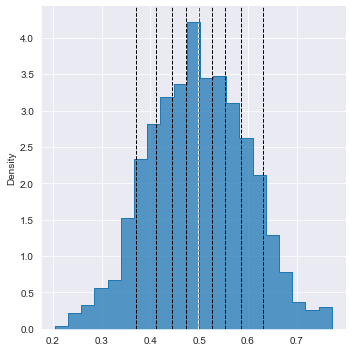

In [314]:
## Normal

points = distributions["normal"].rvs(N_samples)

print(f"{percentile}th percentile around mean: {percentile_around_mean(points, percentile)}")
print(f"{percentile}th percentile around median: {percentile_around_median(points, percentile)}")

plot_distribution_sns(points, element="step", stat="density")
plot_lines(points)

50th percentile around mean: (0.22748903240482643, 0.5499163400980114)
50th percentile around median: (0.22301808732890055, 0.5451296966930476)


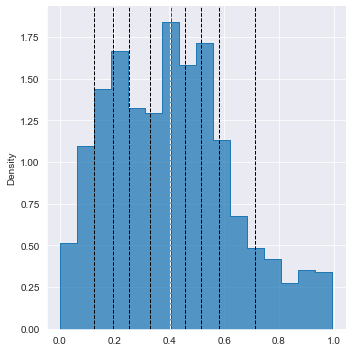

In [315]:
## Fancy
points = Fancy(distributions).rvs(N_samples)

print(f"{percentile}th percentile around mean: {percentile_around_mean(points, percentile)}")
print(f"{percentile}th percentile around median: {percentile_around_median(points, percentile)}")

plot_distribution_sns(points, element="step", stat="density")
plot_lines(points)

# Variations in point estimates

The goal of sampling from the population is to estimate *statistics* of the population. But by definition, this is not a perfect process. Each random sampling (or random variable) will be different, even though they sample from the same population.

In [316]:
VARIATIONS = 100
SAMPLE_SIZE = 10

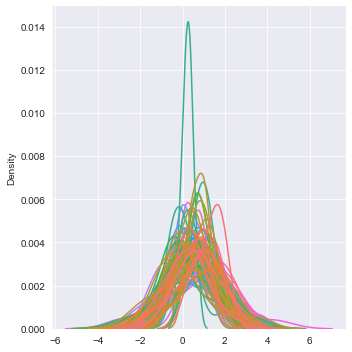

In [317]:
## Normal

df = pd.DataFrame()
for i in range(VARIATIONS):
    df[i] = stats.norm(.5, 1).rvs(SAMPLE_SIZE)
plot_distribution_sns(df, kind='kde', legend=False)

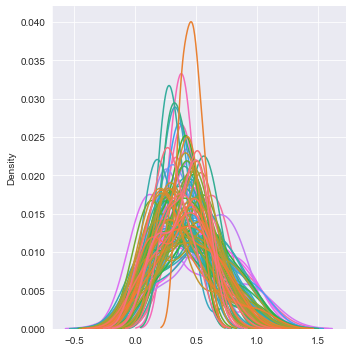

In [318]:
## Fancy

df = pd.DataFrame()
for i in range(VARIATIONS):
    df[i] = Fancy(distributions).rvs(SAMPLE_SIZE)
plot_distribution_sns(df, kind='kde', legend=False)

## The Law of Large Numbers

says that the sample statistic estimates the true statistic as the number of samples drawn grows to `∞`. 

Below, we visualize this as variations in emperical distributions:

In [319]:
VARIATIONS = 100
SAMPLE_SIZE = 1000

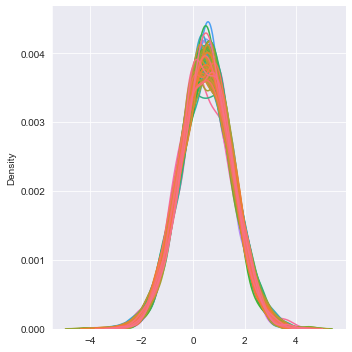

In [320]:
## Normal

df = pd.DataFrame()
for i in range(VARIATIONS):
    df[i] = stats.norm(.5, 1).rvs(SAMPLE_SIZE)
plot_distribution_sns(df, kind='kde', legend=False)

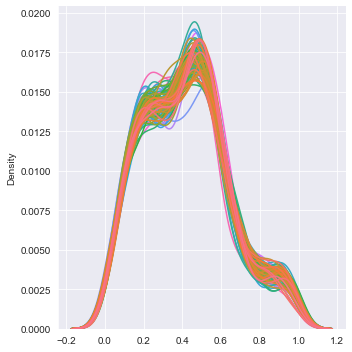

In [321]:
## Fancy

df = pd.DataFrame()
for i in range(VARIATIONS):
    df[i] = Fancy(distributions).rvs(SAMPLE_SIZE)
plot_distribution_sns(df, kind='kde', legend=False)

For lesser random samples, the variations are large. With more and more samples, these variations smoothen out. And in the limiting case of `number of samples -> ∞`, the point estimates of the emperical distribution approach the true point estimates (of the population).

This motivates the next section, where we quantify these variations (in the non-limiting case) using **confidence intervals**.

## Sampling Distribution

A *sampling distribution* is a distribution of a point estimate (also called *statistic*) across multiple random variables in a population. Practically speaking, for each emperical distribution we calculate the same statistic, and consider the distribtuion of the resulting random variable.

In [322]:
VARIATIONS = 100
N_samples = 1000

Mean: 0.4169282522631271
Std dev: 0.00649946005945189


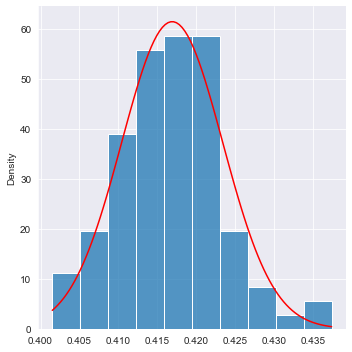

In [323]:
## Fancy
distr = Fancy(distributions)
fancy_means = [np.mean(distr.rvs(N_samples)) for i in range(VARIATIONS)]
print_stats(fancy_means)
fit_to_distr(fancy_means, stats.norm)

Mean: 0.499626101804289
Std dev: 0.0030120759648268568


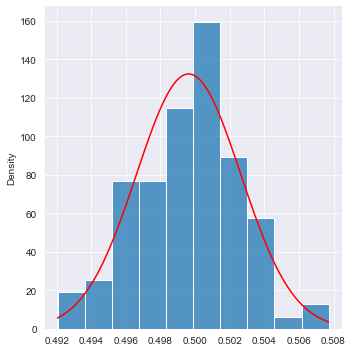

In [324]:
## Normal
distr = stats.norm(.5,.1)
norm_means = [np.mean(distr.rvs(N_samples)) for i in range(VARIATIONS)]
print_stats(norm_means)
fit_to_distr(norm_means, stats.norm)

## Central Limit Theorem

given a sufficiently large sample size, **the sampling distribution of the mean for a r.v will approximate a normal distribution** regardless of that r.v’s distribution in the population.

**NOTE:** This block is a more concrete formulation of the C.L.T. Feel free to skip, if you have seen this before.



Fortunately for us, point estimates like mean, median and mode coincide in a NORMAL distribution. Also, it has nice closed forms for interval estimates.

In [325]:
def percentile_around_mean_normal(mean, std, q=.95):
    distr = stats.norm(mean, std)
    return distr.ppf((1-q)/2), distr.ppf(q+(1-q)/2)

mean = .5
std = .1
q = .95
assert percentile_around_mean_normal(mean, std, q) == stats.norm.interval(alpha=q, loc=mean, scale=std)

In [326]:
percentile = 95

In [327]:
## Fancy
print(f"{percentile}% confidence interval for the mean")
print(percentile_around_mean_normal(np.mean(fancy_means), np.std(fancy_means), q=percentile/100))
print(f"{np.mean(fancy_means)} ± {1.96*np.std(fancy_means)}")

95% confidence interval for the mean
(0.40418954462764484, 0.4296669598986093)
0.4169282522631271 ± 0.012738941716525704


In [328]:
## Normal
print(f"{percentile}% confidence interval for the mean")
print(percentile_around_mean_normal(np.mean(norm_means), np.std(norm_means), q=percentile/100))
print(f"{np.mean(norm_means)} ± {1.96*np.std(norm_means)}")

95% confidence interval for the mean
(0.49372254139452965, 0.5055296622140484)
0.499626101804289 ± 0.005903668891060639


## Bootstrapping

Above, we estimated the sampling distribution by repeating the same experiment multiple times. But this is not realistic. **Bootstrapping** is a way to estimate the sampling distribution, without doing that. The bootstrapping principle is based on *resampling* (≈ sampling with replacement) from a *single* emperical distribution, multiple times.

Let `F` be the true distribution of a population and `x` a true statistic. Let `F̅` be an emperical distribution of a random sampling of `F`, and `x̄` be the corresponding sample statistic. A sampling distribution of `x` estimates variations in `x`, which is equivalent to estimating the distribution of `x̄ - x`.

Say we *sample* (with replacement) from `F̅`, to get the distribution `F*` and the corresponding statistic `x*`. Then the sampling distribution of `x̄` is equivalent to estimating the distribution of `x* - x̄`.

**The Bootstrapping principle** says that these two distributions are equivalent, that is:
```
distr(x̄ - x) ≈ distr(x* - x̄)

```

Since we can *resample* from the emperical distribution `F̅` as many times as we want, it is easier to estimate the distribution of `x* - x̄`. We can then construct interval estimates (≈ confidence intervals) for `x* - x̄`, which would also hold for `x̄ - x`. hence, giving us estimates for `x`.

In [336]:
N_samples = 1000
N_bootstraps = 1000
q = 80

### Emperical Bootstrap

Makes no assumptions about the true or emperical distributions.

In [337]:
def emperical_bootstrap(points, N_bootstraps=1000, q=80, plot=False, fmt="r-"):
    mu_ = np.mean(points) 
    deltas = [np.mean(random.choices(points, k=len(points))) - mu_ for i in range(N_bootstraps)]
    
    if plot:
#         print_stats(deltas)
        fit_to_distr(deltas, stats.norm, fmt=fmt)
    
    # percentile around the median
    lower, upper = np.percentile(deltas, 50 - q/2), np.percentile(deltas, 50 + q/2)
    return mu_-upper, mu_-lower

80th percentile: (0.4113922280242721, 0.43025670398581395)
TRUE: 0.4210058725820852


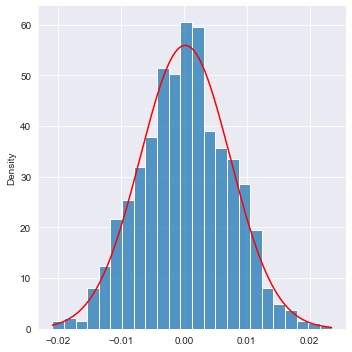

In [338]:
# Fancy

points = Fancy(distributions).rvs(N_samples)
lower, upper = emperical_bootstrap(points, N_bootstraps, q, plot=True)
print(f"{q}th percentile: ({lower}, {upper})")
print(f"TRUE: {np.mean(points)}")

80th percentile: (0.4950129133422359, 0.5031643506961004)
TRUE: 0.5


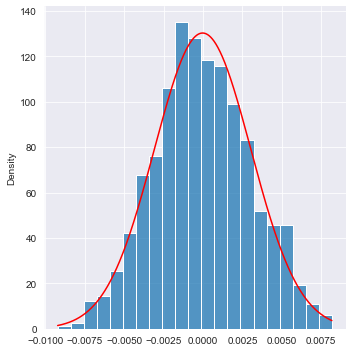

In [339]:
# Normal

points = stats.norm(.5,.1).rvs(N_samples)
lower, upper = emperical_bootstrap(points, N_bootstraps, q, plot=True)
print(f"{q}th percentile: ({lower}, {upper})")
print(f"TRUE: {0.5}")

### Parametric bootstrap

Assumes a family for the emperical distribution and fits the data, before resampling

In [340]:
def parametric_bootstrap(distr, points, N_bootstraps=1000, q=80, plot=False, fmt="r-"):
    mu_ = np.mean(points) 
    deltas = [distr.rvs() - mu_ for i in range(N_bootstraps)]
    
    if plot:
#         print_stats(deltas)
        fit_to_distr(deltas, stats.norm, fmt=fmt)
    
    # percentile around the median
    lower, upper = np.percentile(deltas, 50 - q/2), np.percentile(deltas, 50 + q/2)
    return mu_-upper, mu_-lower

80th percentile: (0.5917468043738319, 0.6303933434378177)
TRUE: 0.6


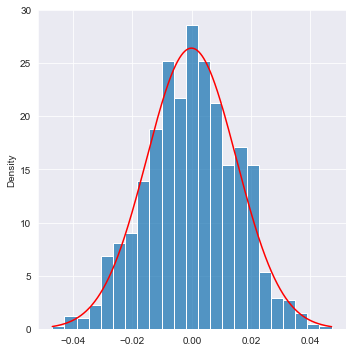

In [341]:
## Bernoulli
P = 0.6

## simulate a population. mostly seen in binary metrics like Reservation Rate
bernoulli = stats.bernoulli(P)
points = bernoulli.rvs(N_samples)

## assume beta distribution for mean and fit
distr = stats.beta(np.sum([np.array(points)==1]), np.sum([np.array(points)==0]))

## parametric bootstrap
lower, upper = parametric_bootstrap(distr, points, N_bootstraps, q, plot=True)
print(f"{q}th percentile: ({lower}, {upper})")
print(f"TRUE: {P}")

# Epilogue

As a prologue to the next session, we'll assume a different distribution in the previous example.

Normal: blue
80th percentile: (0.47573434952702265, 0.7370122670670692)
Beta: red
80th percentile: (0.5839151787821395, 0.6250180542840019)
TRUE: 0.6


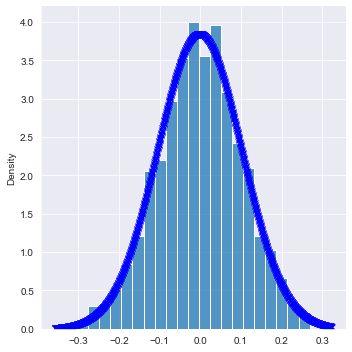

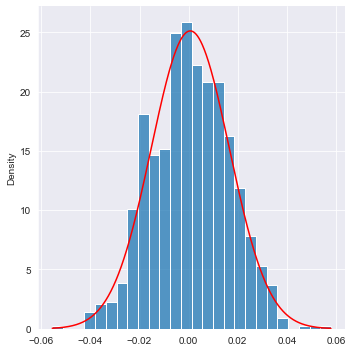

In [342]:
## Bernoulli
P = 0.6

## simulate a population. mostly seen in binary metrics like Reservation Rate
bernoulli = stats.bernoulli(P)
points = bernoulli.rvs(N_samples)

## Normal - blue
print("Normal: blue")
std = .1
norm = stats.norm(np.mean(points), std)
lower, upper = parametric_bootstrap(norm, points, N_bootstraps, q, plot=True, fmt="bx")
print(f"{q}th percentile: ({lower}, {upper})")

## Beta - red
print("Beta: red")
beta = stats.beta(np.sum([np.array(points)==1]), np.sum([np.array(points)==0]))
lower, upper = parametric_bootstrap(beta, points, N_bootstraps, q, plot=True, fmt="r-")
print(f"{q}th percentile: ({lower}, {upper})")
print(f"TRUE: {P}")